In [1]:
import math, random
from collections import namedtuple, deque
from itertools import count

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T

import gym

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2021-07-17 00:11:32.537 Python[10112:850577] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/qk/jdhw_kk14pb15_g7glpg8vbm0000gn/T/org.python.python.savedState


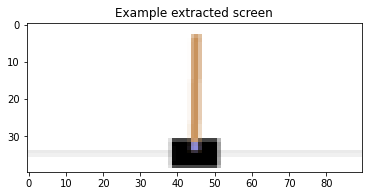

In [3]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=T.functional.InterpolationMode.BICUBIC),
    T.ToTensor()
])

def get_cart_location(screen_w):
    world_w = env.x_threshold * 2
    scale = screen_w / world_w
    return int(screen_w / 2 + scale * env.state[0])

def get_screen():
    screen = env.render(mode='rgb_array').transpose(2, 0, 1) # env.render retuns HWC; so transpose it to CHW order
    _, screen_h, screen_w = screen.shape

    screen = screen[:, int(screen_h * 0.4):int(screen_h * 0.8), :]

    view_w = int(screen_w * 0.6)
    cart_location = get_cart_location(screen_w)
    if cart_location < view_w // 2:
        slice_range = slice(view_w)
    elif cart_location > (screen_w - view_w // 2):
        slice_range = slice(-view_w, None)
    else:
        slice_range = slice(cart_location - view_w // 2, cart_location + view_w // 2)
    
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0) # resize and add a batch dimension; BCHW

env.reset()
plt.title('Example extracted screen')
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
env.close()

In [4]:
Transition = namedtuple(
    typename='Transition',
    field_names=('state', 'action', 'next_state', 'reward')
)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, k=batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    def __init__(self, h, w, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_out_size(size, kernel_size=5, stride=2):
            return (size - kernel_size) // stride + 1
        conv_h = conv2d_out_size(conv2d_out_size(conv2d_out_size(h)))
        conv_w = conv2d_out_size(conv2d_out_size(conv2d_out_size(w)))

        self.head = nn.Linear(32 * conv_h * conv_w, out_features)

    def forward(self, x):
        x = x.to(device)
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [6]:
_, _, screen_h, screen_w = get_screen().shape
n_actions = env.action_space.n

policy_net = DQN(screen_h, screen_w, n_actions).to(device)
target_net = DQN(screen_h, screen_w, n_actions).to(device)
target_net.load_state_dict(state_dict=policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda _lr: _lr * 0.995)
memory = ReplayMemory(50000)

batch_size = 32
gamma = 0.98
eps_start = 0.1
eps_end = 0.01
eps_decay = 200
target_update = 20

def select_action(state, episode):
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1 * episode / eps_decay)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(dim=1)[0].detach()
    expected_state_action_values = reward_batch + gamma * next_state_values

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(dim=1))
    optimizer.zero_grad()
    loss.backward()
    for p in policy_net.parameters():
        p.grad.data.clamp_(min=-1, max=1)
    optimizer.step()
    # scheduler.step()


In [7]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    plt.title('Score over episodes')
    plt.xlabel('episode')
    plt.ylabel('score')

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.plot(durations_t.numpy(), label='score')
    if len(durations_t) >= 100:
        means = durations_t.unfold(dimension=0, size=100, step=1).mean(dim=1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='100 mean score')
    plt.legend(loc='lower right')
    plt.show()

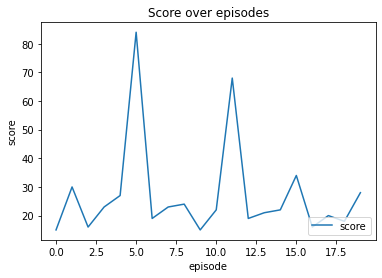

In [8]:
n_episodes = 10000
for epi in range(1, n_episodes + 1):
    env.reset()
    last_screen = get_screen()
    env.step(random.randrange(n_actions))
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count(2):
        action = select_action(state, epi)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        last_screen, current_screen = current_screen, get_screen()
        next_state = None if done else (current_screen - last_screen)
        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()

        if done:
            episode_durations.append(t)
            break

    if epi % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        plot_durations()

print('Complete')
env.render()
env.close()

$\textbf{Note:}$ Highly unstable; It many times fails to learn and is extremely sensitive to initial states and hyperparameters.

[Reference](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)